In [1]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

plt.style.use('seaborn')


# Packages for modeling
from keras import models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utkarsh.Goyal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
3889,@united this is getting ridiculous. Now we're ...,negative
11670,@USAirways ticket couldnt be used bc unable to...,negative
13924,@AmericanAir i will be writing a very detailed...,negative
6619,@SouthwestAir in my 30 years of flying I have ...,negative
8105,@JetBlue great flight! Great view! :-) http://...,positive


In [4]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 

In [5]:
df.text = df.text.apply(remove_stopwords)
df.head()

,text,airline_sentiment
3889,@united getting ridiculous. Now we're missing ...,negative
11670,@USAirways ticket couldnt used bc unable get d...,negative
13924,@AmericanAir writing detailed letter experienc...,negative
6619,@SouthwestAir 30 years flying never pissed off...,negative
8105,@JetBlue great flight! Great view! :-) http://...,positive


In [6]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
    
df.text = df.text.apply(remove_mentions)
df.head()

,text,airline_sentiment
3889,getting ridiculous. Now we're missing connect...,negative
11670,ticket couldnt used bc unable get departing d...,negative
13924,writing detailed letter experience today. nev...,negative
6619,30 years flying never pissed off. To many inc...,negative
8105,great flight! Great view! :-) http://t.co/Yxn...,positive


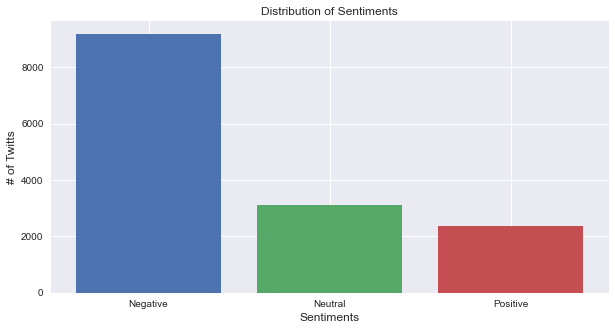

In [7]:
plt.figure(figsize=(10, 5))
plt.bar('Negative', len(df[df['airline_sentiment']=='negative']))
plt.bar('Neutral', len(df[df['airline_sentiment']=='neutral']))
plt.bar('Positive', len(df[df['airline_sentiment']=='positive']))

plt.title('Distribution of Sentiments', size=12)
plt.xlabel('Sentiments', size=12)
plt.ylabel('# of Twitts', size=12);

In [8]:
sentiment_dict = {'negative':1, 'positive':2, 'neutral':0}

In [9]:
df['sentiment'] = df['airline_sentiment'].map(sentiment_dict)

In [10]:
df.drop(columns=['airline_sentiment'], inplace=True)
df.head()

,text,sentiment
3889,getting ridiculous. Now we're missing connect...,1
11670,ticket couldnt used bc unable get departing d...,1
13924,writing detailed letter experience today. nev...,1
6619,30 years flying never pissed off. To many inc...,1
8105,great flight! Great view! :-) http://t.co/Yxn...,2


In [24]:
df.loc[8105, 'text']

' great flight! Great view! :-) http://t.co/Yxn00pnOav'

# Modeling

In [32]:
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
df_log = df.copy()

In [34]:
def preprocessor(text):

    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'\$\w*','', text)
    text = re.sub(r'^RT[\s]+','', text)
    text = re.sub(r'http\S+','', text)
    text = re.sub(r'#','', text)
    text = text.lower()

    return text

df_log['text'] = df_log['text'].apply(preprocessor)

In [36]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [37]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        tokenizer=tokenizer_porter,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

X = tfidf.fit_transform(df_log['text'])
y = df_log['sentiment'].values

In [38]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [39]:
model_params = {
'svm': {
        'model': svm.SVC(gamma='auto',max_iter=-1),
        'params' : {
            'C': [1,10,20],
            'kernel': ['linear', 'rbf',],
            #'shrinking':['True', 'False']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,100],
            'max_depth': [1,2,3,4,5,6],
            'min_samples_leaf': [100,200,300,500,1000]
        }
    },
    
    
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['newton-cg', 'liblinear']
        }
    },

    'kneighbours': {
        'model': KNeighborsClassifier(n_jobs=-1),
        "params": {
            
            'n_neighbors' : [5, 10 , 100],
        }
    },

}

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_.round(4),
        'best_params': clf.best_params_
    })

svm
random_forest
logistic_regression
kneighbours


In [41]:
rel = pd.DataFrame(scores,columns=['model','best_score','best_params'])
rel.sort_values('best_score', ascending=False)

,model,best_score,best_params
2,logistic_regression,0.7945,"{'C': 5, 'solver': 'liblinear'}"
0,svm,0.7909,"{'C': 1, 'kernel': 'linear'}"
3,kneighbours,0.7120,{'n_neighbors': 100}
1,random_forest,0.6380,"{'max_depth': 5, 'min_samples_leaf': 100, 'n_e..."


The results from the table tells us that we should use logistic regression with the following best parameters.

## Using the best model as baseline

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [44]:
model = LogisticRegression(multi_class='auto', C=5, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=5, solver='liblinear')

In [45]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
y_pred = model.predict(X_test)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

---Test Set Results---
Accuracy with logreg: 0.7974726775956285
              precision    recall  f1-score   support

           0       0.65      0.55      0.60       620
           1       0.83      0.92      0.87      1836
           2       0.82      0.63      0.71       472

    accuracy                           0.80      2928
   macro avg       0.77      0.70      0.73      2928
weighted avg       0.79      0.80      0.79      2928



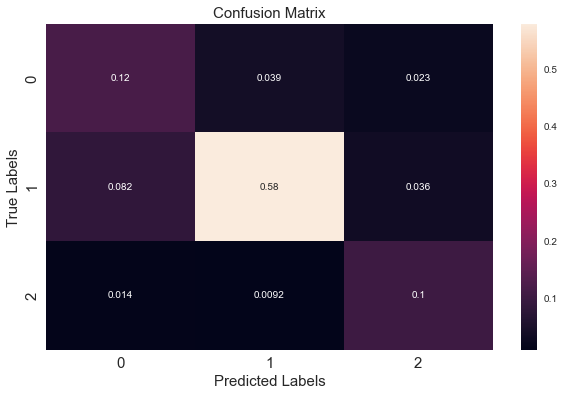

In [46]:
import seaborn as sns

matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1,2], size=15)
ax.yaxis.set_ticklabels([0,1,2], size=15);

# Keras

In [47]:
import tensorflow as tf

In [48]:
X = df['text']
y = df['sentiment']

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [50]:
import re

def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        
        i = re.sub('<[^>]*>', '', i)
        i = re.sub(r'[^\w\s]','', i)
        i = re.sub(r'\$\w*','', i)
        i = re.sub(r'^RT[\s]+','', i)
        i = re.sub(r'http\S+','', i)
        i = re.sub(r'#','', i)
        
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [51]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [53]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding=padding_type, truncating=trunc_type, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [55]:
input_dim = X_train.shape[1]

In [56]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

# Modeling-Keras

### Embedding

In [57]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
tf.keras.layers.Dropout(0.25, name="dropout"),
tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,737,667
Trainable params: 2,737,667
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
352/352 [==============================] - 4s 9ms/step - loss: 0.9156 - accuracy: 0.6261 - val_loss: 0.8981 - val_accuracy: 0.6254
Epoch 2/10
352/352 [==============================] - 3s 9ms/step - loss: 0.8858 - accuracy: 0.6270 - val_loss: 0.8719 - val_accuracy: 0.6254
Epoch 3/10
352/352 [==============================] - 3s 9ms/step - loss: 0.8644 - accuracy: 0.6277 - val_loss: 0.8553 - val_accuracy: 0.6254
Epoch 4/10
352/352 [==============================] - 3s 9ms/step - loss: 0.8615 - accuracy: 0.6338 - val_loss: 0.8519 - val_accuracy: 0.6254
Epoch 5/10
352/352 [==============================] - 3s 9ms/step - loss: 0.8576 - accuracy: 0.6333 - val_loss: 0.8542 - val_accuracy: 0.6391
Epoch 6/10
352/352 [==============================] - 3s 9ms/step - loss: 0.8580 - accuracy: 0.6322 - val_loss: 0.8615 - val_accuracy: 0.6288


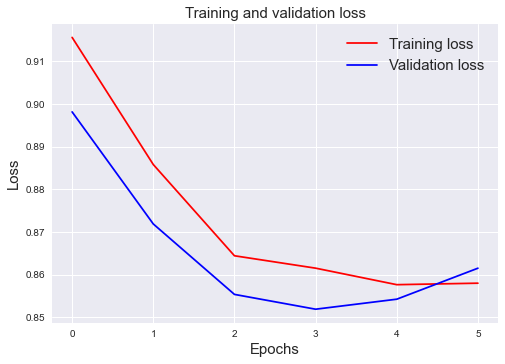

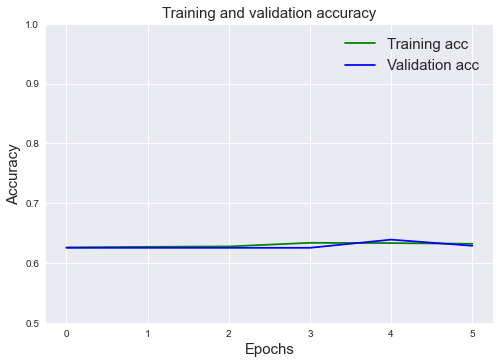

In [60]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [61]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)
binary_predictions = [np.argmax(element) for element in pred]

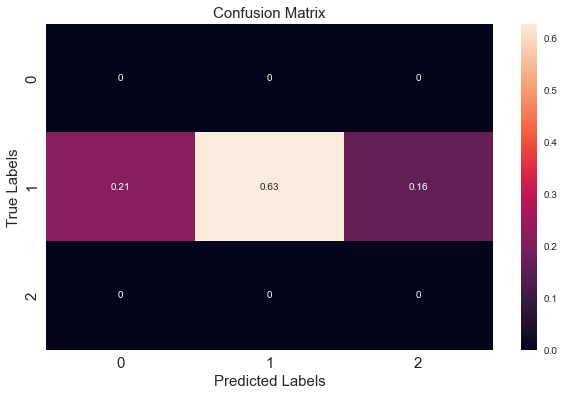

In [62]:
import seaborn as sns


matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1,2], size=15)
ax.yaxis.set_ticklabels([0,1,2], size=15);

This model proforms very poorly given that it labels everything as 1 (the most common value).

## LSTM

In [66]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
tf.keras.layers.Dropout(0.1, name="dropout"),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 256, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         66048     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 747,459
Trainable params: 747,459
Non-tr

In [67]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
352/352 [==============================] - 85s 227ms/step - loss: 0.9280 - accuracy: 0.6250 - val_loss: 0.9178 - val_accuracy: 0.6254
Epoch 2/10
352/352 [==============================] - 84s 237ms/step - loss: 0.9134 - accuracy: 0.6270 - val_loss: 0.9140 - val_accuracy: 0.6254
Epoch 3/10
352/352 [==============================] - 82s 233ms/step - loss: 0.9073 - accuracy: 0.6270 - val_loss: 0.9075 - val_accuracy: 0.6254
Epoch 4/10
352/352 [==============================] - 84s 239ms/step - loss: 0.8949 - accuracy: 0.6270 - val_loss: 0.8849 - val_accuracy: 0.6254
Epoch 5/10
352/352 [==============================] - 85s 242ms/step - loss: 0.8697 - accuracy: 0.6270 - val_loss: 0.8587 - val_accuracy: 0.6254
Epoch 6/10
352/352 [==============================] - 88s 249ms/step - loss: 0.8538 - accuracy: 0.6326 - val_loss: 0.8519 - val_accuracy: 0.6271
Epoch 7/10
352/352 [==============================] - 86s 243ms/step - loss: 0.8501 - accuracy: 0.6403 - val_loss: 0.8518 - val_ac

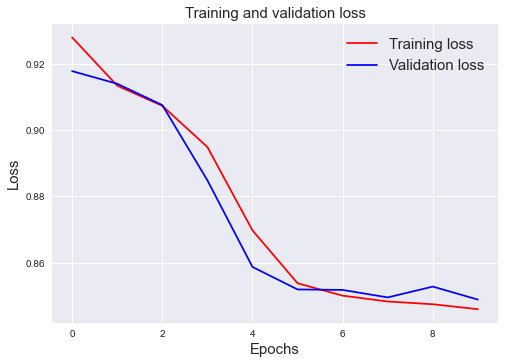

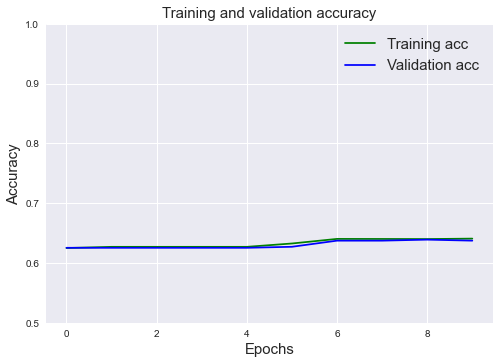

In [69]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

# plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

# plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=15)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

In [70]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pred = model.predict(X_test)
binary_predictions = [np.argmax(element) for element in pred]

print("---Test Set Results---")
print("Accuracy: {}".format(accuracy_score(y_test, binary_predictions)))
print(classification_report(y_test, binary_predictions))

---Test Set Results---
Accuracy: 0.6454918032786885
              precision    recall  f1-score   support

         0.0       0.41      0.27      0.32       620
         1.0       0.68      0.94      0.79      1836
         2.0       0.00      0.00      0.00       472

    accuracy                           0.65      2928
   macro avg       0.36      0.40      0.37      2928
weighted avg       0.52      0.65      0.56      2928



C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


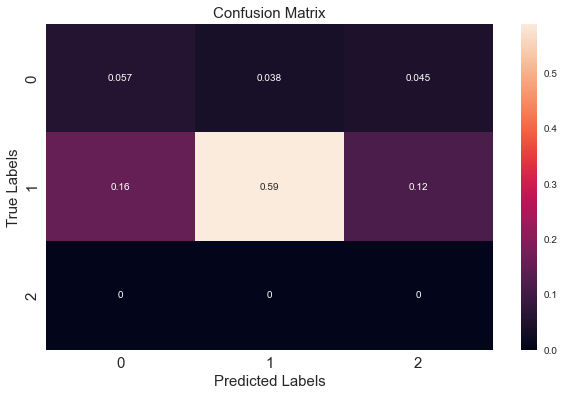

In [71]:
import seaborn as sns

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1,2], size=15)
ax.yaxis.set_ticklabels([0,1,2], size=15);